In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('KepRiau 2015 - 2022.csv')

# Convert 'datetime' column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' column as index
data.set_index('datetime', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define your input and output variables
X = data_scaled[:, 1].reshape(-1, 1)  # 'total_accomodation' as input
y = data_scaled[:, 0]  # 'total_visitor' as output



80 : 20

In [20]:
# Split the data into training and testing sets (70:30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10],
              'epsilon': [0.01, 0.1, 1, 10]}

# Create an SVR model
svr = SVR(kernel='rbf')

# Perform grid search
grid_search = GridSearchCV(svr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 10}


In [29]:
# Build and Train the SVR Model
svr_model = SVR(kernel='rbf', C=10, gamma=10, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]
y_test_inv = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Squared Error (MSE): 11387293.245211797
Mean Absolute Error (MAE): 3168.97476400798
Mean Absolute Percentage Error (MAPE): 28.97%


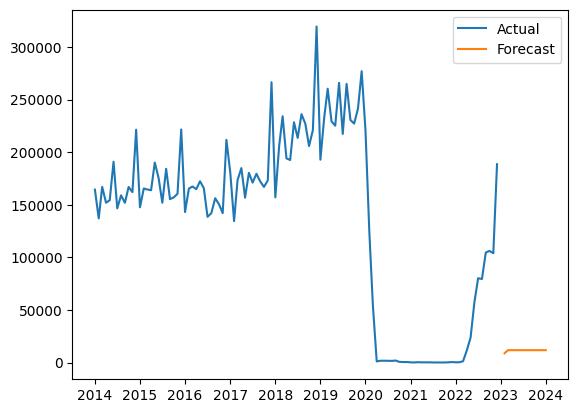

In [32]:
# Forecasting
# Forecast for the next 12 periods
future_periods = 12
X_future = np.linspace(X[-1], X[-1] + future_periods, future_periods).reshape(-1, 1)
y_future_pred = svr_model.predict(X_future)

# Inverse transform the scaled predictions
y_future_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros_like(y_future_pred), y_future_pred)))[:, 1]

# Create a date range for the future periods
future_dates = pd.date_range(start=data.index[-1], periods=future_periods + 1, freq='M')[1:]

# Plot the results
plt.plot(data.index, data['total_visitor'], label='Actual')
plt.plot(future_dates, y_future_pred_inv, label='Forecast')
plt.legend()
plt.show()